In [3]:
pip show torch


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, BertForSequenceClassification, pipeline
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch

In [3]:
df = pd.read_csv("I:/darkparttren_detection/Dataset/cleaned_file.csv")
df.head()

,text,label,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,Pillowcases & Shams,0,Not Dark Pattern
2,Write a review,0,Not Dark Pattern
3,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,newsletter signup (privacy policy),0,Not Dark Pattern


In [4]:
fine = df['category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [5]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [6]:
id2fine

{0: 'Urgency',
 1: 'Not Dark Pattern',
 2: 'Scarcity',
 3: 'Misdirection',
 4: 'Social Proof',
 5: 'Obstruction',
 6: 'Sneaking',
 7: 'Forced Action'}

In [7]:
fine2id

{'Urgency': 0,
 'Not Dark Pattern': 1,
 'Scarcity': 2,
 'Misdirection': 3,
 'Social Proof': 4,
 'Obstruction': 5,
 'Sneaking': 6,
 'Forced Action': 7}

In [8]:
df.drop('label', axis=1, inplace=True)

In [9]:
df.head()

,text,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,Pillowcases & Shams,Not Dark Pattern
2,Write a review,Not Dark Pattern
3,"To start your return, simply click on the foll...",Not Dark Pattern
4,newsletter signup (privacy policy),Not Dark Pattern


In [10]:
df['labels']=df.category.map(lambda x: fine2id[x.strip()])

In [11]:
df

,text,category,labels
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,Pillowcases & Shams,Not Dark Pattern,1
2,Write a review,Not Dark Pattern,1
3,"To start your return, simply click on the foll...",Not Dark Pattern,1
4,newsletter signup (privacy policy),Not Dark Pattern,1
...,...,...,...
3863,TWO FREE PILLOWS AND 30% OFF WITH PROMO CODE,Misdirection,3
3864,Compare at,Misdirection,3
3865,$132.90 $99.00,Misdirection,3
3866,This offer is only VALID if you add to cart now!,Misdirection,3


<Axes: ylabel='count'>

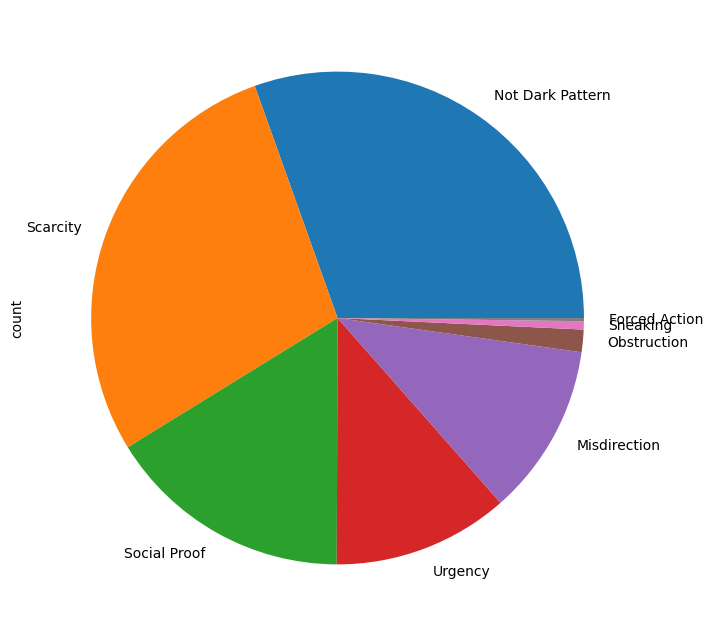

In [12]:
df.category.value_counts().plot(kind='pie', figsize=(8,8))

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", max_length=512)

C:\Users\win10\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\win10\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_fine,
                                                      id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2:(3%SIZE)//4])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
if len(val_texts) > 0:
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
else:
    val_encodings = None  # or handle it accordingly)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./TTC4908Model",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()